# Raster Data and Projections

In this tutorial, we will walk through examples of reprojecting raster datasets and working with coordinate transformations with GDAL. We will focus on these common operations 

1. Converting coordinates from one projection system to another
2. Reprojecting geocoded rasters 
3. Reprojecting swath data
   - Using GCPs
   - Using geolocation arrays

We assume that you have already completed the tutorial on raster data manipulation and are familiar with raster data representation in GDAL.

## Let's begin

Some imports and utility functions that we will use throughout the notebook.

In [1]:
###The usual python imports for the notebook
%matplotlib notebook
from osgeo import gdal, ogr, osr
import matplotlib.pyplot as plt

gdal.UseExceptions()

#Utility function to load data
def loadData(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    #Data array
    data = ds.GetRasterBand(band).ReadAsArray()
    #Map extent
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
            trans[3] + ysize*trans[5], trans[3]]
    
    ds = None
    return data, extent


And let's also download some SRTM data from southern California

In [ ]:
#Grab some SRTM data using the OpenTopography API
!curl -X GET "https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&south=34&north=35&west=-120&east=-119&outputFormat=GTiff" -H "accept: */*" --output N34W120.tif

## gdalwarp

We will be using the **gdalwarp** utility either as an executable or programatically for accomplishing all the above listed data manipulation operations in this tutorial. For list of options supported by **gdalwarp**, see  

http://www.gdal.org/gdalwarp.html

```bash
gdalwarp [--help-general] [--formats]
    [-s_srs srs_def] [-t_srs srs_def] [-to "NAME=VALUE"]* [-novshiftgrid]
    [-order n | -tps | -rpc | -geoloc] [-et err_threshold]
    [-refine_gcps tolerance [minimum_gcps]]
    [-te xmin ymin xmax ymax] [-te_srs srs_def]
    [-tr xres yres] [-tap] [-ts width height]
    [-ovr level|AUTO|AUTO-n|NONE] [-wo "NAME=VALUE"] [-ot Byte/Int16/...] [-wt Byte/Int16]
    [-srcnodata "value [value...]"] [-dstnodata "value [value...]"]
    [-srcalpha|-nosrcalpha] [-dstalpha]
    [-r resampling_method] [-wm memory_in_mb] [-multi] [-q]
    [-cutline datasource] [-cl layer] [-cwhere expression]
    [-csql statement] [-cblend dist_in_pixels] [-crop_to_cutline]
    [-of format] [-co "NAME=VALUE"]* [-overwrite]
    [-nomd] [-cvmd meta_conflict_value] [-setci] [-oo NAME=VALUE]*
    [-doo NAME=VALUE]*
    srcfile* dstfile
```

## 1. Coordinate conversion

GDAL's coordinate conversion engine is built on top of the PROJ.4 library (https://proj4.org/). We will walk through some examples of converting coordinates from one system to another. To keep things simple, we will use EPSG codes (http://www.epsg.org/) and PROJ.4 representations for commonly used coordinate systems. A table of commonly used systems on the WGS84 are shown below.

<table>
    <thead>
        <tr>
            <td>EPSG code</td><td>PROJ.4 string</td><td>Common name</td>
        </tr>
    </thead>
    <tr>
        <td>4326</td><td>+proj=longlat +datum=WGS84 +no_defs</td><td>WGS84 Lon/Lat</td>
    </tr>
    <tr>
        <td>3031</td><td>+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1</td><td>Antarctic Polar Stereographic</td>
    </tr>
    <tr>
        <td>3413</td><td>+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs</td><td>NSIDC Polar Stereographic North</td>
    </tr>
    <tr>
        <td>32600+X</td><td>+proj=utm +zone=X +datum=WGS84 +units=m +no_defs</td><td>Standard UTM zone North</td>
    </tr>
    <tr>
        <td>32700+X</td><td>+proj=utm +zone=X +south +datum=WGS84 +units=m +no_defs</td><td>Standard UTM zone South</td>
    </tr>
</table>        

We will use the **gdaltransform** utility to convert coordinates on the command line (https://www.gdal.org/gdaltransform.html). We will also demonstrate the programmatic way of converting coordinates using GDAL's python bindings.

### a. Horizontal transformations

Most common map transformations change the horizontal datum, i.e, the height axis is usually always considered to be normal to the Ellipsoid. This is the case with transformations between the systems listed above. 

Lets demonstrate this with the example of Polar Stereographic North (EPSG:3413) system, whose origin is at 90N, 45W and is often used for datasets over Greenland.

In [ ]:
#From lon/lat to polar
!echo "-45.0 90.0" | gdaltransform -s_srs EPSG:4326 -t_srs EPSG:3413

In [ ]:
#from polar to lon/lat
!echo "0 0" | gdaltransform -s_srs EPSG:3413 -t_srs EPSG:4326

In [2]:
##Programmatic method of coordinate transformation
##We will use EPSG/PROJ.4. You can also use ImportFromProj or ImportFromWKT
def getTransformers(inproj, outproj, epsg=True):
    '''
    inproj - Projection system 1
    outproj - Projection system 2
    '''
    
    proj1 = osr.SpatialReference()
    if epsg:
        proj1.ImportFromEPSG(int(inproj))
    else:
        proj1.ImportFromProj4(str(inproj))
    
    proj2 = osr.SpatialReference()
    if epsg:
        proj2.ImportFromEPSG(int(outproj))
    else:
        proj2.ImportFromProj4(str(outproj))
    
    fwd = osr.CoordinateTransformation(proj1, proj2)
    inv = osr.CoordinateTransformation(proj2, proj1)
    return fwd, inv

In [ ]:
###Create transformer for Antarctic Polar Stereographic
fwdtrans, invtrans = getTransformers(4326, 3031)
print('Forward: ', fwdtrans.TransformPoint(0., -90., 450.))
print('Inverse: ', invtrans.TransformPoint(0., 0., -233.))

We can also verify transformations against online calculators. For example, use this:
http://www.rcn.montana.edu/resources/converter.aspx

In [ ]:
lon, lat = -118.0, 35.0       ##Example point in CA
xx, yy = 408746.7, 3873499.9  ##Coordinate from calculator above

fwd, inv = getTransformers(4326, 32611)
print('Forward: ', fwd.TransformPoint(lon,lat), [xx,yy])
print('Inverse: ', inv.TransformPoint(xx, yy), [lon, lat])

### b. Horizontal + vertical datum transformation

Coordinate system transformation also supports some vertical datums (same as PROJ.4 vgrid). 

We will demonstrate this with the EGM96 grid. Remember that SRTM DEM is referenced to EGM96 geoid. This implies that zero height at the coast, does not necessarily mean zero ellipsoid height. For radar processing, we use all heights w.r.t to an Ellipsoid (for efficient computing).

Some standard vertical datums also have their own EPSG codes. Shown below is the table for the 2 most commonly used geoids

| EPSG code | Name of Geoid |  URL  | 
|-----------|---------------|-------|
| 5773      | EGM 96|https://en.wikipedia.org/wiki/EGM96 |
| 3885      | EGM 08|http://earth-info.nga.mil/GandG/wgs84/gravitymod/egm2008/egm08_wgs84.html |


GDAL provides a short hand for representing geoid information with the EPSG code - EPSG:4326 + 5773 represents lon/lat horizontal datum and EGM96 vertical datum. We will quickly perform some transformations with this representation.

In [ ]:
#Check PROJ.4 representation
!gdalsrsinfo EPSG:4326+5773

In [ ]:
# A point on the CA coast that reads zero height in SRTM data
!echo "-118.506 34.015" | gdaltransform -s_srs EPSG:4326+5773 -t_srs EPSG:4326

Note that for all radar processing, we use Ellipsoid heights. So for the point of interest above, we would use a DEM height of -36m for processing. 

We can now **gdalwarp** to quickly transform geoid heights to Ellipsoid heights and visualize the difference.

In [ ]:
#Note that this only works for a single band image.
#For multi-band images, vertical datum is ignored.
!gdalwarp -of GTiff N34W120.tif -overwrite -srcnodata None -s_srs EPSG:4326+5773 -t_srs EPSG:4326 N34W120_wgs84.tif 

In [ ]:
gDEM, ext = loadData('N34W120.tif')
eDEM, ext = loadData('N34W120_wgs84.tif')
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(gDEM, extent=ext)
plt.colorbar()
plt.title('SRTM DEM')
plt.subplot(1,2,2)
plt.imshow(gDEM-eDEM, extent=ext)
plt.colorbar()
plt.title('EGM96')
plt.show()

## 2. Reprojecting geocoded rasters

There are numerous use cases where geocoded data needs to be reprojected. Some examples are listed below:

1. A region of interest is too large for analysis with a single UTM zone (e.g, Landsat data). To create a large mosaic, reprojection is unavoidable.

2. Putting together DEMs from different sources. SRTM only spans the latitudes from 60N to 60S. For Arctic regions, DEMs are typically distributed in Polar Stereographic coordinates. For processing, a single DEM would need to be built by projecting DEMs to a common system.

3. Certain projections are more conducive for comparison against field datasets - e.g UTM zones where pixel dimensions can be directly related to area on ground.

4. Combining data from different sources. For example, SRTM dataset is distributed in lat/lon coordinates whereas Landsat and Sentinel-2 is distributed in UTM/ Polar Stereographic coordinates.

In this section, we will use **gdalwarp** to reproject data from one coordinate system to another. 

### a. Simple reprojection

The key flags for **gdalwarp** for reprojection are 

1. "-t_srs" option to indicate the output projection system 
2. "-r" option for the resampling algorithm
3. "-te" option for the spatial extent of the output grid
4. "-tr" option for controlling the spacing of the output grid (or) "-ts" option for output size

To start, let's reproject the Greenland DEM to default output extent and spacing that is automatically determined for WGS84 lat/lon coordinates.

In [ ]:
!gdalwarp -t_srs EPSG:4326 NETCDF:"Greenland1km.nc":topg -srcnodata None -dstnodata None -overwrite Greenland_ll_default.tif

In [ ]:
pdem, pext = loadData('NETCDF:"Greenland1km.nc":topg')
ldem, lext = loadData('Greenland_ll_default.tif')

plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(pdem, extent=pext)
plt.subplot(1,2,2)
plt.imshow(ldem, extent=lext)
plt.show()
print('Original DEM size: ', pdem.shape)
print('Resampled DEM size: ', ldem.shape)
pdem = None
ldem = None

### b. Resample with specific output spacing

Remember from the earlier exercise that the Greenland DEM was sampled at a spacing of about 1km. We can use a similar number for resampling. 

In [ ]:
!gdalwarp -t_srs EPSG:4326 -tr 0.06 0.01 -overwrite NETCDF:"Greenland1km.nc":topg -srcnodata None -dstnodata None Greenland_ll_similar.tif

In [ ]:
pdem, pext = loadData('NETCDF:"Greenland1km.nc":topg')
ldem, lext = loadData('Greenland_ll_similar.tif')

plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(pdem, extent=pext)
plt.subplot(1,2,2)
plt.imshow(ldem, extent=lext)
plt.show()
print('Original DEM size: ', pdem.shape)
print('Resampled DEM size: ', ldem.shape)
pdem = None
ldem = None

### c. Resampling to a predefined grid

This is a very useful feature to automatically output data to a grid that is self-consistent. Such grids typically are laid out in a manner where the starting coordinates are a multiple of pixel spacing. This is accomplished via the "-tap" option and most useful for efficient operations.

Let's reproject subsets of a DEM to same coordinate system with and without "-tap" option and compare the output grids.

In [ ]:
##Lets subset without the -tap option
!gdalwarp -of VRT -t_srs EPSG:32611 -te -119.8 34.3 -119.6 34.5 -te_srs EPSG:4326 -tr 100 100 N34W120.tif subset1.vrt
!gdalwarp -of VRT -t_srs EPSG:32611 -te -119.9 34.2 -119.7 34.4 -te_srs EPSG:4326 -tr 100 100 N34W120.tif subset2.vrt

In [ ]:
!gdalinfo subset1.vrt

In [ ]:
!gdalinfo subset2.vrt

Note that the outputs are not aligned, i.e the top-left corners do not vary by a multiple of pixel spacing. Now, lets try with the "-tap" option.

In [ ]:
##Lets subset with the -tap option
!gdalwarp -of VRT -t_srs EPSG:32611 -te -119.8 34.3 -119.6 34.5 -te_srs EPSG:4326 -tr 100 100 -tap N34W120.tif subset3.vrt
!gdalwarp -of VRT -t_srs EPSG:32611 -te -119.9 34.2 -119.7 34.4 -te_srs EPSG:4326 -tr 100 100 -tap N34W120.tif subset4.vrt

In [ ]:
!gdalinfo subset3.vrt

In [ ]:
!gdalinfo subset4.vrt

Note that the top-left pixels now differ exactly by a multiple of the pixel spacing. These subsets can be easily overlaid on top of each other for analysis / comparison without additional processing.

## 3. Reproject swath data

From the ISCE processing examples, you must have noticed that SAR imagery is not distributed on grids that is aligned North-South, West-East. The imaging grid is aligned to the track of the satellite or aircraft and these may not be perfectly North-South. GDAL provides two options for geocoding this type of dataset

1. Ground Control Points (GCPs)
2. Geolocation arrays

### a. Geocoding using GCPs

In the introductory tutorial on raster data, we have already seen that some data formats include support for GCPs. These represent a mapping between line/pixel and map coordinates. Over very flat terrain or over ocean / sea ice - this information is more than sufficient to geocode data reasonably accurately (think why???). We just outline the procedure in this tutorial due to time constraints. Users are encouraged to try this on their own.

```bash
> gdalinfo /vsizip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.zip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.SAFE/measurement/s1a-iw-grd-vv-20170127t001111-20170127t001136-015010-01884a-001.tiff

Driver: GTiff/GeoTIFF
Files: /vsizip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.zip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.SAFE/measurement/s1a-iw-grd-vv-20170127t001111-20170127t001136-015010-01884a-001.tiff
Size is 25505, 16729
Coordinate System is `'
GCP Projection =
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["unnamed",6378137,298.2572235604902,
            AUTHORITY["EPSG","4326"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
GCP[  0]: Id=1, Info=
          (0,0) -> (-94.005922908642,33.2767568872629,82.4891335545108)
GCP[  1]: Id=2, Info=
          (1276,0) -> (-93.8713725178248,33.298342788709,82.4890268715099)
GCP[  2]: Id=3, Info=
          (2552,0) -> (-93.736756133881,33.3197832475533,82.4889215333387)
GCP[  3]: Id=4, Info=
          (3828,0) -> (-93.6020741174325,33.3410780749001,82.4888174766675)
GCP[  4]: Id=5, Info=
          (5104,0) -> (-93.4673268317664,33.3622270828064,82.4887146400288)
GCP[  5]: Id=6, Info=
          (6380,0) -> (-93.3325146423635,33.3832300843644,82.4886129721999)
GCP[  6]: Id=7, Info=
          (7656,0) -> (-93.1976379167661,33.404086893728,82.4885124303401)
GCP[  7]: Id=8, Info=
          (8932,0) -> (-93.0626970245939,33.4247973261167,82.488412976265)
GCP[  8]: Id=9, Info=
          (10208,0) -> (-92.9276923375967,33.4453611978123,82.4883145680651)
GCP[  9]: Id=10, Info=
          (11484,0) -> (-92.7926242296921,33.4657783261598,82.4882171778008)
GCP[ 10]: Id=11, Info=
          (12760,0) -> (-92.6574930769715,33.4860485295715,82.4881207821891)
GCP[ 11]: Id=12, Info=
          (14036,0) -> (-92.5222992576794,33.5061716275367,82.4880253477022)
GCP[ 12]: Id=13, Info=
          (15312,0) -> (-92.387043152181,33.5261474406317,82.4879308547825)
GCP[ 13]: Id=14, Info=
          (16588,0) -> (-92.2517251429341,33.5459757905291,82.4878372829407)
GCP[ 14]: Id=15, Info=
          (17864,0) -> (-92.1163456144782,33.5656565000047,82.487744611688)
GCP[ 15]: Id=16, Info=
          (19140,0) -> (-91.9809049534456,33.5851893929409,82.4876528279856)
GCP[ 16]: Id=17, Info=
          (20416,0) -> (-91.845403548587,33.6045742943281,82.4875619197264)
GCP[ 17]: Id=18, Info=
          (21692,0) -> (-91.7098417907929,33.6238110302665,82.4874718654901)
GCP[ 18]: Id=19, Info=
          (22968,0) -> (-91.5742200730755,33.6428994279739,82.4873826541007)
GCP[ 19]: Id=20, Info=
          (24244,0) -> (-91.4385387904629,33.6618393158058,82.4872942790389)
GCP[ 20]: Id=21, Info=
          (25504,0) -> (-91.3045007790343,33.6803958180407,82.487207817845)
GCP[ 21]: Id=22, Info=
          (0,2008) -> (-94.047689959274,33.4574743168206,86.8307519014925)
GCP[ 22]: Id=23, Info=
          (1276,2008) -> (-93.9128610831397,33.4790567161726,86.8306398028508)
GCP[ 23]: Id=24, Info=
          (2552,2008) -> (-93.7779655913483,33.500492683175,86.8305291002616)
GCP[ 24]: Id=25, Info=
          (3828,2008) -> (-93.6430038546116,33.5217820267718,86.8304197173566)
GCP[ 25]: Id=26, Info=
          (5104,2008) -> (-93.507976245905,33.5429245569615,86.8303116057068)
GCP[ 26]: Id=27, Info=
          (6380,2008) -> (-93.3728831400487,33.563920084869,86.8302047140896)
GCP[ 27]: Id=28, Info=
          (7656,2008) -> (-93.2377249136249,33.5847684227625,86.8300989894196)
GCP[ 28]: Id=29, Info=
          (8932,2008) -> (-93.1025019450354,33.6054693840483,86.8299943935126)
GCP[ 29]: Id=30, Info=
          (10208,2008) -> (-92.9672146145922,33.6260227832614,86.8298908965662)
GCP[ 30]: Id=31, Info=
          (11484,2008) -> (-92.8318633045886,33.6464284360586,86.8297884585336)
GCP[ 31]: Id=32, Info=
          (12760,2008) -> (-92.696448399334,33.6666861592187,86.8296870533377)
GCP[ 32]: Id=33, Info=
          (14036,2008) -> (-92.5609702851583,33.686795770646,86.8295866586268)
GCP[ 33]: Id=34, Info=
          (15312,2008) -> (-92.4254293504009,33.7067570893768,86.8294872529805)
GCP[ 34]: Id=35, Info=
          (16588,2008) -> (-92.2898259854009,33.7265699355856,86.8293888093904)
GCP[ 35]: Id=36, Info=
          (17864,2008) -> (-92.1541605825019,33.7462341305888,86.8292913101614)
GCP[ 36]: Id=37, Info=
          (19140,2008) -> (-92.0184335360754,33.7657494968454,86.8291947441176)
GCP[ 37]: Id=38, Info=
          (20416,2008) -> (-91.8826452425569,33.7851158579568,86.8290990917012)
GCP[ 38]: Id=39, Info=
          (21692,2008) -> (-91.7467961004747,33.8043330386673,86.8290043342859)
GCP[ 39]: Id=40, Info=
          (22968,2008) -> (-91.6108865104378,33.8234008648703,86.8289104709402)
GCP[ 40]: Id=41, Info=
          (24244,2008) -> (-91.474916875033,33.8423191636278,86.8288174821064)
GCP[ 41]: Id=42, Info=
          (25504,2008) -> (-91.3405936623981,33.8608533477523,86.8287265086547)
GCP[ 42]: Id=43, Info=
          (0,4016) -> (-94.0896851063414,33.6381587216162,83.1414270717651)
GCP[ 43]: Id=44, Info=
          (1276,4016) -> (-93.9545737968323,33.6597382189906,83.1413188902661)
GCP[ 44]: Id=45, Info=
          (2552,4016) -> (-93.8193953343885,33.6811702724005,83.1412120880559)
GCP[ 45]: Id=46, Info=
          (3828,4016) -> (-93.6841500913544,33.7024546902725,83.1411065980792)
GCP[ 46]: Id=47, Info=
          (5104,4016) -> (-93.5488384429507,33.7235912819923,83.1410023635253)
GCP[ 47]: Id=48, Info=
          (6380,4016) -> (-93.4134607667759,33.7445798579914,83.1408993322402)
GCP[ 48]: Id=49, Info=
          (7656,4016) -> (-93.2780174426532,33.7654202297782,83.1407974530011)
GCP[ 49]: Id=50, Info=
          (8932,4016) -> (-93.1425088526288,33.7861122099448,83.1406966922805)
GCP[ 50]: Id=51, Info=
          (10208,4016) -> (-93.0069353810106,33.8066556121666,83.1405970100313)
GCP[ 51]: Id=52, Info=
          (11484,4016) -> (-92.8712974143956,33.827050251205,83.1404983736575)
GCP[ 52]: Id=53, Info=
          (12760,4016) -> (-92.7355953416676,33.847295942914,83.1404007524252)
GCP[ 53]: Id=54, Info=
          (14036,4016) -> (-92.5998295539722,33.86739250425,83.1403041221201)
GCP[ 54]: Id=55, Info=
          (15312,4016) -> (-92.4640004446803,33.8873397532833,83.1402084585279)
GCP[ 55]: Id=56, Info=
          (16588,4016) -> (-92.3281084093585,33.9071375092078,83.1401137458161)
GCP[ 56]: Id=57, Info=
          (17864,4016) -> (-92.1921538457568,33.9267855923485,83.1400199588388)
GCP[ 57]: Id=58, Info=
          (19140,4016) -> (-92.0561371538186,33.9462838241655,83.139927085489)
GCP[ 58]: Id=59, Info=
          (20416,4016) -> (-91.9200587357033,33.9656320272558,83.139835103415)
GCP[ 59]: Id=60, Info=
          (21692,4016) -> (-91.7839189958028,33.9848300253565,83.1397440042347)
GCP[ 60]: Id=61, Info=
          (22968,4016) -> (-91.6477183407148,34.0038776433544,83.1396537711844)
GCP[ 61]: Id=62, Info=
          (24244,4016) -> (-91.5114571791219,34.0227747073074,83.1395643977448)
GCP[ 62]: Id=63, Info=
          (25504,4016) -> (-91.3768456493388,34.0412869145492,83.1394769735634)
GCP[ 63]: Id=64, Info=
          (0,6024) -> (-94.1314913043126,33.8188767279123,94.8706692503765)
GCP[ 64]: Id=65, Info=
          (1276,6024) -> (-93.9960966137392,33.8404529544535,94.8705469993874)
GCP[ 65]: Id=66, Info=
          (2552,6024) -> (-93.8606341419723,33.8618807384932,94.8704262357205)
GCP[ 66]: Id=67, Info=
          (3828,6024) -> (-93.7251042712821,33.8831598863366,94.8703068885952)
GCP[ 67]: Id=68, Info=
          (5104,6024) -> (-93.5895073864032,33.9042902053498,94.8701889030635)
GCP[ 68]: Id=69, Info=
          (6380,6024) -> (-93.4538438741112,33.9252715040336,94.8700722213835)
GCP[ 69]: Id=70, Info=
          (7656,6024) -> (-93.3181141231331,33.9461035920414,94.8699568007141)
GCP[ 70]: Id=71, Info=
          (8932,6024) -> (-93.1823185241957,33.9667862801773,94.8698425991461)
GCP[ 71]: Id=72, Info=
          (10208,6024) -> (-93.0464574701047,33.9873193803885,94.8697295757011)
GCP[ 72]: Id=73, Info=
          (11484,6024) -> (-92.9105313558033,34.0077027057613,94.8696177061647)
GCP[ 73]: Id=74, Info=
          (12760,6024) -> (-92.7745405783956,34.0279360705236,94.8695069514215)
GCP[ 74]: Id=75, Info=
          (14036,6024) -> (-92.638485537139,34.0480192900511,94.8693972947076)
GCP[ 75]: Id=76, Info=
          (15312,6024) -> (-92.5023666334231,34.0679521808751,94.869288709946)
GCP[ 76]: Id=77, Info=
          (16588,6024) -> (-92.3661842707519,34.0877345606912,94.8691811719909)
GCP[ 77]: Id=78, Info=
          (17864,6024) -> (-92.2299388547413,34.1073662483635,94.8690746631473)
GCP[ 78]: Id=79, Info=
          (19140,6024) -> (-92.093630793139,34.1268470639269,94.8689691703767)
GCP[ 79]: Id=80, Info=
          (20416,6024) -> (-91.9572604958582,34.1461768285875,94.8688646741211)
GCP[ 80]: Id=81, Info=
          (21692,6024) -> (-91.8208283750074,34.1653553647229,94.8687611622736)
GCP[ 81]: Id=82, Info=
          (22968,6024) -> (-91.6843348448802,34.1843824958893,94.8686586217955)
GCP[ 82]: Id=83, Info=
          (24244,6024) -> (-91.5477803218575,34.2032580468394,94.8685570405796)
GCP[ 83]: Id=84, Info=
          (25504,6024) -> (-91.4128786394285,34.2217480026286,94.868457662873)
GCP[ 84]: Id=85, Info=
          (0,8032) -> (-94.1726812320393,33.9996951265157,145.826850661077)
GCP[ 85]: Id=86, Info=
          (1276,8032) -> (-94.037000633364,34.0212674230856,145.826668350957)
GCP[ 86]: Id=87, Info=
          (2552,8032) -> (-93.9012516560656,34.0426902688802,145.826487941667)
GCP[ 87]: Id=88, Info=
          (3828,8032) -> (-93.7654346892336,34.0639634686949,145.826309361495)
GCP[ 88]: Id=89, Info=
          (5104,8032) -> (-93.6295501244325,34.0850868284084,145.826132549904)
GCP[ 89]: Id=90, Info=
          (6380,8032) -> (-93.4935983552818,34.1060601550547,145.825957460329)
GCP[ 90]: Id=91, Info=
          (7656,8032) -> (-93.3575797773681,34.126883256842,145.825784043409)
GCP[ 91]: Id=92, Info=
          (8932,8032) -> (-93.2214947882966,34.1475559431492,145.825612259097)
GCP[ 92]: Id=93, Info=
          (10208,8032) -> (-93.0853437877728,34.1680780245185,145.825442066416)
GCP[ 93]: Id=94, Info=
          (11484,8032) -> (-92.9491271776626,34.188449312651,145.825273439288)
GCP[ 94]: Id=95, Info=
          (12760,8032) -> (-92.8128453620176,34.2086696204089,145.825106347911)
GCP[ 95]: Id=96, Info=
          (14036,8032) -> (-92.67649874707,34.2287387618212,145.824940763414)
GCP[ 96]: Id=97, Info=
          (15312,8032) -> (-92.5400877412122,34.2486565520923,145.824776669964)
GCP[ 97]: Id=98, Info=
          (16588,8032) -> (-92.4036127549806,34.2684228076089,145.824614039622)
GCP[ 98]: Id=99, Info=
          (17864,8032) -> (-92.2670742010541,34.2880373459456,145.824452857487)
GCP[ 99]: Id=100, Info=
          (19140,8032) -> (-92.1304724942741,34.3074999858663,145.824293107726)
GCP[100]: Id=101, Info=
          (20416,8032) -> (-91.9938080516782,34.3268105473252,145.824134772643)
GCP[101]: Id=102, Info=
          (21692,8032) -> (-91.8570812925285,34.3459688514672,145.823977841064)
GCP[102]: Id=103, Info=
          (22968,8032) -> (-91.7202926382989,34.3649747206351,145.823822300881)
GCP[103]: Id=104, Info=
          (24244,8032) -> (-91.5834425125734,34.3838279783886,145.823668140918)
GCP[104]: Id=105, Info=
          (25504,8032) -> (-91.4482484714778,34.4022949074902,145.823517258279)
GCP[105]: Id=106, Info=
          (0,10040) -> (-94.2139238725098,34.1805072851632,198.548701436259)
GCP[106]: Id=107, Info=
          (1276,10040) -> (-94.0779547882432,34.2020757807732,198.548456720077)
GCP[107]: Id=108, Info=
          (2552,10040) -> (-93.9419167279478,34.2234938122191,198.548214334995)
GCP[108]: Id=109, Info=
          (3828,10040) -> (-93.805810087086,34.2447611828731,198.547974212095)
GCP[109]: Id=110, Info=
          (5104,10040) -> (-93.6696352636983,34.2658776971961,198.54773629643)
GCP[110]: Id=111, Info=
          (6380,10040) -> (-93.5333926579617,34.2868431608136,198.547500534914)
GCP[111]: Id=112, Info=
          (7656,10040) -> (-93.3970826720872,34.307657380537,198.54726688005)
GCP[112]: Id=113, Info=
          (8932,10040) -> (-93.2607057103604,34.3283201643619,198.547035292722)
GCP[113]: Id=114, Info=
          (10208,10040) -> (-93.124262179218,34.3488313214617,198.546805738471)
GCP[114]: Id=115, Info=
          (11484,10040) -> (-92.9877524873046,34.3691906621842,198.546578184702)
GCP[115]: Id=116, Info=
          (12760,10040) -> (-92.851177045497,34.3893979980535,198.546352600679)
GCP[116]: Id=117, Info=
          (14036,10040) -> (-92.7145362668988,34.4094531417768,198.546128966846)
GCP[117]: Id=118, Info=
          (15312,10040) -> (-92.5778305668214,34.4293559072516,198.545907253399)
GCP[118]: Id=119, Info=
          (16588,10040) -> (-92.4410603627686,34.4491061095739,198.545687450096)
GCP[119]: Id=120, Info=
          (17864,10040) -> (-92.3042260744354,34.4687035650432,198.545469530858)
GCP[120]: Id=121, Info=
          (19140,10040) -> (-92.1673281237276,34.4881480911647,198.545253487304)
GCP[121]: Id=122, Info=
          (20416,10040) -> (-92.0303669347938,34.5074395066495,198.545039299875)
GCP[122]: Id=123, Info=
          (21692,10040) -> (-91.8933429340491,34.5265776314174,198.544826953672)
GCP[123]: Id=124, Info=
          (22968,10040) -> (-91.7562565501562,34.5455622866038,198.54461644683)
GCP[124]: Id=125, Info=
          (24244,10040) -> (-91.6191082139124,34.5643932945809,198.544407761656)
GCP[125]: Id=126, Info=
          (25504,10040) -> (-91.4836192368266,34.5828372353663,198.544203476049)
GCP[126]: Id=127, Info=
          (0,12048) -> (-94.25432309759,34.3614557730504,302.946729348972)
GCP[127]: Id=128, Info=
          (1276,12048) -> (-94.1180621814358,34.383019675634,302.946361161768)
GCP[128]: Id=129, Info=
          (2552,12048) -> (-93.9817317837367,34.4044320795243,302.945996158756)
GCP[129]: Id=130, Info=
          (3828,12048) -> (-93.8453322976822,34.4256927883587,302.945634277537)
GCP[130]: Id=131, Info=
          (5104,12048) -> (-93.7088641201605,34.4468016066707,302.945275451057)
GCP[131]: Id=132, Info=
          (6380,12048) -> (-93.5723276511671,34.4677583399954,302.944919633679)
GCP[132]: Id=133, Info=
          (7656,12048) -> (-93.4357232935763,34.4885627949145,302.944566783495)
GCP[133]: Id=134, Info=
          (8932,12048) -> (-93.2990514530748,34.5092147790767,302.94421685487)
GCP[134]: Id=135, Info=
          (10208,12048) -> (-93.1623125381443,34.5297141012091,302.943869820796)
GCP[135]: Id=136, Info=
          (11484,12048) -> (-93.0255069600393,34.5500605711292,302.943525647745)
GCP[136]: Id=137, Info=
          (12760,12048) -> (-92.8886351327418,34.5702539997606,302.943184312433)
GCP[137]: Id=138, Info=
          (14036,12048) -> (-92.7516974728963,34.5902941991506,302.942845787853)
GCP[138]: Id=139, Info=
          (15312,12048) -> (-92.6146943997393,34.6101809824883,302.94251004979)
GCP[139]: Id=140, Info=
          (16588,12048) -> (-92.4776263350394,34.6299141641203,302.942177088931)
GCP[140]: Id=141, Info=
          (17864,12048) -> (-92.3404937030593,34.6494935595636,302.941846882924)
GCP[141]: Id=142, Info=
          (19140,12048) -> (-92.203296930544,34.6689189855134,302.941519422457)
GCP[142]: Id=143, Info=
          (20416,12048) -> (-92.0660364467276,34.6881902598488,302.941194689833)
GCP[143]: Id=144, Info=
          (21692,12048) -> (-91.9287126833378,34.7073072016389,302.940872677602)
GCP[144]: Id=145, Info=
          (22968,12048) -> (-91.7913260745629,34.7262696311536,302.940553373657)
GCP[145]: Id=146, Info=
          (24244,12048) -> (-91.6538770569317,34.7450773698865,302.940236770548)
GCP[146]: Id=147, Info=
          (25504,12048) -> (-91.5180907266005,34.7634973083089,302.93992678076)
GCP[147]: Id=148, Info=
          (0,14056) -> (-94.2969246946118,34.5420594060516,289.679583688267)
GCP[148]: Id=149, Info=
          (1276,14056) -> (-94.1603681371615,34.5636216263085,289.679230171256)
GCP[149]: Id=150, Info=
          (2552,14056) -> (-94.0237415667509,34.5850313088514,289.678879768588)
GCP[150]: Id=151, Info=
          (3828,14056) -> (-93.8870453754225,34.6062882573308,289.678532412276)
GCP[151]: Id=152, Info=
          (5104,14056) -> (-93.7502799599306,34.6273922761226,289.678188038059)
GCP[152]: Id=153, Info=
          (6380,14056) -> (-93.6134457210128,34.6483431704603,289.677846601233)
GCP[153]: Id=154, Info=
          (7656,14056) -> (-93.4765430630425,34.6691407465041,289.677508051507)
GCP[154]: Id=155, Info=
          (8932,14056) -> (-93.3395723938599,34.6897848113797,289.677172348835)
GCP[155]: Id=156, Info=
          (10208,14056) -> (-93.2025341246687,34.710275173207,289.676839462481)
GCP[156]: Id=157, Info=
          (11484,14056) -> (-93.0654286699406,34.7306116411265,289.676509361714)
GCP[157]: Id=158, Info=
          (12760,14056) -> (-92.9282564473089,34.7507940253259,289.67618201673)
GCP[158]: Id=159, Info=
          (14036,14056) -> (-92.7910178774539,34.7708221370681,289.675857400522)
GCP[159]: Id=160, Info=
          (15312,14056) -> (-92.6537133839908,34.7906957887171,289.675535497256)
GCP[160]: Id=161, Info=
          (16588,14056) -> (-92.5163433933767,34.8104147937606,289.675216287374)
GCP[161]: Id=162, Info=
          (17864,14056) -> (-92.378908334844,34.829978966828,289.674899755977)
GCP[162]: Id=163, Info=
          (19140,14056) -> (-92.2414086403649,34.8493881237039,289.674585882574)
GCP[163]: Id=164, Info=
          (20416,14056) -> (-92.1038447446349,34.8686420813381,289.674274659716)
GCP[164]: Id=165, Info=
          (21692,14056) -> (-91.9662170850546,34.8877406578559,289.673966070637)
GCP[165]: Id=166, Info=
          (22968,14056) -> (-91.8285261016697,34.9066836725741,289.673660114408)
GCP[166]: Id=167, Info=
          (24244,14056) -> (-91.6907722370178,34.9254709460289,289.6733567724)
GCP[167]: Id=168, Info=
          (25504,14056) -> (-91.5546844246163,34.943869644052,289.673059795983)
GCP[168]: Id=169, Info=
          (0,16064) -> (-94.3390836183297,34.7227358640494,306.064091209322)
GCP[169]: Id=170, Info=
          (1276,16064) -> (-94.2022389900078,34.7442943444211,306.063717443496)
GCP[170]: Id=171, Info=
          (2552,16064) -> (-94.0653231775186,34.7656993670926,306.063346951269)
GCP[171]: Id=172, Info=
          (3828,16064) -> (-93.9283366316392,34.7869507241728,306.062979667448)
GCP[172]: Id=173, Info=
          (5104,16064) -> (-93.7912798016242,34.8080482097263,306.062615531497)
GCP[173]: Id=174, Info=
          (6380,16064) -> (-93.654153135386,34.828991619729,306.062254494056)
GCP[174]: Id=175, Info=
          (7656,16064) -> (-93.5169570799065,34.8497807519904,306.061896506697)
GCP[175]: Id=176, Info=
          (8932,16064) -> (-93.3796920817076,34.870415406069,306.061541529372)
GCP[176]: Id=177, Info=
          (10208,16064) -> (-93.2423585872865,34.8908953831972,306.061189531349)
GCP[177]: Id=178, Info=
          (11484,16064) -> (-93.1049570434748,34.9112204862197,306.06084048003)
GCP[178]: Id=179, Info=
          (12760,16064) -> (-92.9674878977178,34.9313905195468,306.060494344682)
GCP[179]: Id=180, Info=
          (14036,16064) -> (-92.8299515982852,34.9514052891187,306.060151105747)
GCP[180]: Id=181, Info=
          (15312,16064) -> (-92.6923485944371,34.9712646023787,306.059810741805)
GCP[181]: Id=182, Info=
          (16588,16064) -> (-92.5546793365657,34.9909682682498,306.059473229572)
GCP[182]: Id=183, Info=
          (17864,16064) -> (-92.416944276331,35.0105160971143,306.059138556942)
GCP[183]: Id=184, Info=
          (19140,16064) -> (-92.2791438667984,35.0299079007933,306.058806712739)
GCP[184]: Id=185, Info=
          (20416,16064) -> (-92.141278562573,35.0491434925276,306.058477675542)
GCP[185]: Id=186, Info=
          (21692,16064) -> (-92.0033488199136,35.068222686963,306.058151436038)
GCP[186]: Id=187, Info=
          (22968,16064) -> (-91.8653550967926,35.0871453001428,306.057827989571)
GCP[187]: Id=188, Info=
          (24244,16064) -> (-91.7272978528524,35.1059111495157,306.057507327758)
GCP[188]: Id=189, Info=
          (25504,16064) -> (-91.5909098537345,35.1242876858511,306.057193404995)
GCP[189]: Id=190, Info=
          (0,16728) -> (-94.3542122503434,34.782295044955,246.882710632868)
GCP[190]: Id=191, Info=
          (1276,16728) -> (-94.2172619912602,34.8038552608933,246.882406512275)
GCP[191]: Id=192, Info=
          (2552,16728) -> (-94.080240740657,34.8252615995711,246.882105198689)
GCP[192]: Id=193, Info=
          (3828,16728) -> (-93.9431489136834,34.8465138598918,246.881806625053)
GCP[193]: Id=194, Info=
          (5104,16728) -> (-93.8059869285803,34.8676118418325,246.881510730833)
GCP[194]: Id=195, Info=
          (6380,16728) -> (-93.6687552061895,34.8885553465287,246.881217458285)
GCP[195]: Id=196, Info=
          (7656,16728) -> (-93.5314541698086,34.9093441763043,246.88092676457)
GCP[196]: Id=197, Info=
          (8932,16728) -> (-93.3940842451943,34.929978134678,246.880638615228)
GCP[197]: Id=198, Info=
          (10208,16728) -> (-93.2566458606044,34.9504570263632,246.880352959037)
GCP[198]: Id=199, Info=
          (11484,16728) -> (-93.1191394468253,34.9707806572715,246.880069776438)
GCP[199]: Id=200, Info=
          (12760,16728) -> (-92.9815654371698,34.9909488345194,246.879789030179)
GCP[200]: Id=201, Info=
          (14036,16728) -> (-92.8439242674496,35.0109613664389,246.879510701634)
GCP[201]: Id=202, Info=
          (15312,16728) -> (-92.7062163759374,35.0308180625903,246.879234765656)
GCP[202]: Id=203, Info=
          (16588,16728) -> (-92.5684422033351,35.050518733772,246.878961206414)
GCP[203]: Id=204, Info=
          (17864,16728) -> (-92.4306021927598,35.0700631920292,246.878689996898)
GCP[204]: Id=205, Info=
          (19140,16728) -> (-92.2926967897523,35.0894512506582,246.878421133384)
GCP[205]: Id=206, Info=
          (20416,16728) -> (-92.1547264422987,35.1086827242094,246.878154591657)
GCP[206]: Id=207, Info=
          (21692,16728) -> (-92.0166916008444,35.1277574284911,246.87789036613)
GCP[207]: Id=208, Info=
          (22968,16728) -> (-91.8785927182643,35.1466751805799,246.8776284419)
GCP[208]: Id=209, Info=
          (24244,16728) -> (-91.7404302497364,35.1654357988433,246.877368811518)
GCP[209]: Id=210, Info=
          (25504,16728) -> (-91.6039382777295,35.1838068073759,246.877114677802)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_DATETIME=2017:01:27 08:07:14
  TIFFTAG_IMAGEDESCRIPTION=Sentinel-1A IW GRD HR L1
  TIFFTAG_SOFTWARE=Sentinel-1 IPF 002.72
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,16729.0)
Upper Right (25505.0,    0.0)
Lower Right (25505.0,16729.0)
Center      (12752.5, 8364.5)
Band 1 Block=25505x1 Type=UInt16, ColorInterp=Gray
```

To geocode this dataset on a uniform lat/lon grid, we can use 

```bash
> gdalwarp -t_srs EPSG:4326 -tr 0.003 0.003 -r average /vsizip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.zip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.SAFE/measurement/s1a-iw-grd-vv-20170127t001111-20170127t001136-015010-01884a-001.tiff  geocoded_with_gcp.tif
```

There are other input options like the order of polynomial ("-order") and thin plate transformer ("-tps") that allow for further control on geocoding using GCPs.

### b. Geocoding using geolocation arrays

*Note that this section requires you to have processed an interferogram!*

In this section we will provide programmatic examples of how pixel-by-pixel lon/lat or x/y arrays for swath imagery can be used for directly geocoding the data without any specialized radar processing tools. Note that ISCE already generates these files as part of the "topo" processing step in stripmapApp.py or topsApp.py. The main requirement is that these lon/lat or x/y arrays have the same dimensions as the raster image that you are trying to geocode. 

#### Locating a pixel with known location in a SAR/InSAR image

Before moving to geocoding entire images, we often encounter the use case where people want to quickly identify a known feature (say a GPS station or a building) in a radar image. This is often challenging without tools specialized for radar processing. However, if geolocation arrays are available with the radar image- this can be easily accomplished using GDAL's coordinate transformation features. We will demonstrate this with an example.

We have included the outputs from a stripmapApp.py processing run in the subfolder named **stripmap**. This is a pair processed over a very small volcano named Barren Island in the Indian ocean. The peak of this island is known to be located at location 12.27486N, 93.864E. We will try to locate this pixel in the full resolution correlation image in radar coordinates (**topophase.cor.full**). We will use the full resolution lat (**lat.rdr.full**) and lon (**lon.rdr.full**) files for this. 

In [3]:
def radarGeometryTransformer(infile, latfile, lonfile, epsg=4326):
    '''
    Create a coordinate transformer to convert map coordinates to radar image line/pixels.
    '''
    
    driver = gdal.GetDriverByName('VRT')
    inds = gdal.OpenShared(infile, gdal.GA_ReadOnly)
    tempds = driver.Create('', inds.RasterXSize, inds.RasterYSize, 0)
    inds = None
    
    tempds.SetMetadata({'SRS' : 'EPSG:{0}'.format(epsg),
                        'X_DATASET': lonfile,
                        'X_BAND' : '1',
                        'Y_DATASET': latfile,
                        'Y_BAND' : '1',
                        'PIXEL_OFFSET' : '0',
                        'LINE_OFFSET' : '0',
                        'PIXEL_STEP' : '1',
                        'LINE_STEP' : '1'}, 'GEOLOCATION')
    
    trans = gdal.Transformer( tempds, None, ['METHOD=GEOLOC_ARRAY'])
    
    return trans    

In [35]:
###Lets create a transformer for our dataset and test
#trans = radarGeometryTransformer('/Users/jacktarricone/warp_test/jemez_vrt/ele.llh.vrt', 
                                 '/Users/jacktarricone/warp_test/jemez_vrt/lon.llh.vrt',
                                 '/Users/jacktarricone/warp_test/jemez_vrt/lat.llh.vrt')

###Checkour our location of interest
#success, location = trans.TransformPoint(1, 93.864, 12.27486, 0.)
#if not success:
    #print('Location outside the geolocation array range')

IndentationError: unexpected indent (3770094130.py, line 3)

In [41]:
import rasterio
import numpy as np

vstack = '/Users/jacktarricone/warp_test/jemez_vrt/alamos_35915_03_BU_s1_2x8.llh.vrt'
bands = [1]

# define cropping window ((row_start, row_stop), (col_start, col_stop))
window = ((10, 50), (30, 40))

with rasterio.open(vstack) as src:
    array = src.read(vstack[1])

IndexError: band index U out of range (not in (1, 2, 3))

<IPython.core.display.Javascript object>


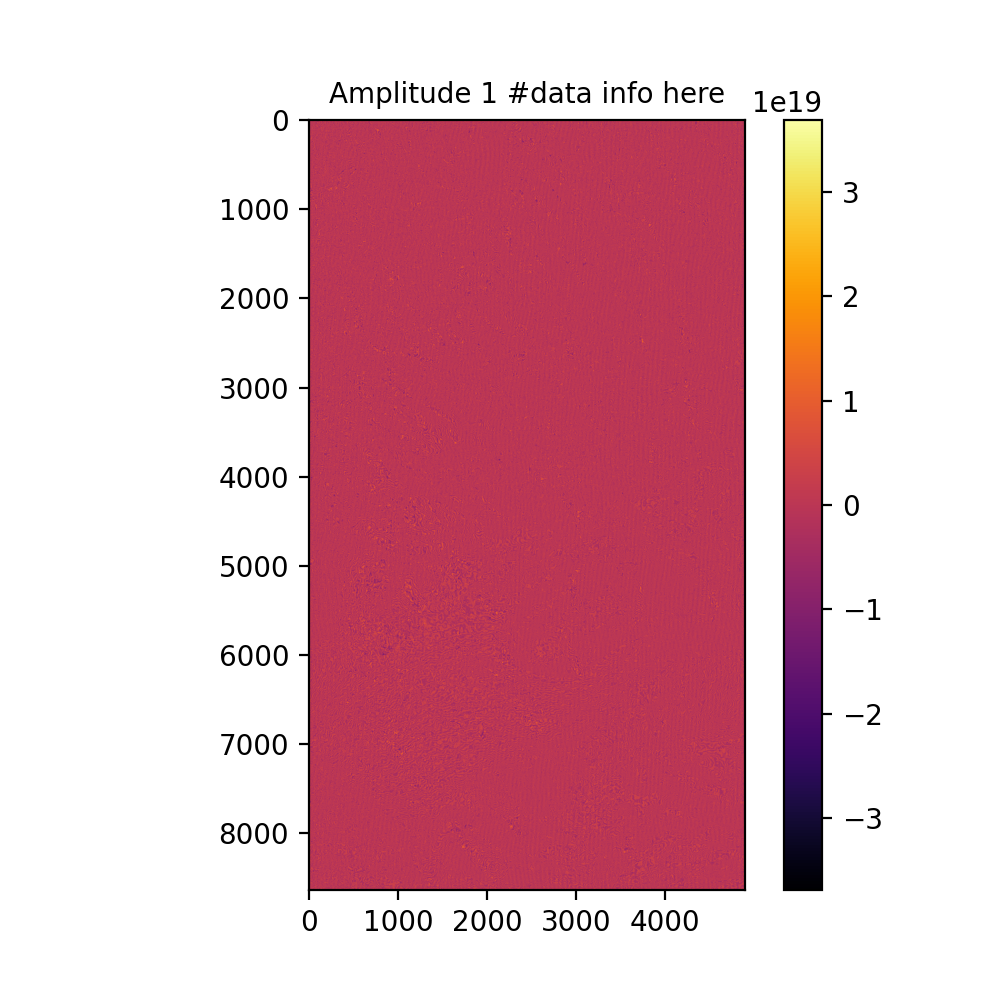

In [44]:
###Lets plot this on a raster to confirm the peak location
data, ext = loadData('/Users/jacktarricone/warp_test/jemez_vrt/lon.llh.vrt')
#plt.figure()
#plt.imshow(data)

#colorbar = fig.colorbar(data, ax=ax)
#plt.show()

# test matplotlib style of plot bc it has color bar
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title("Amplitude 1 #data info here", fontsize= 10)
data_plot = ax.imshow(data,
           cmap='inferno')

# add legend
colorbar = fig.colorbar(data_plot, ax=ax)
plt.show()
#plt.scatter(location[0], location[1], marker='+', c='r')
#plt.show()
#data = None

In [16]:
import rasterio
import rasterio.plot
import glob
import os

In [40]:
with rasterio.open('/Users/jacktarricone/warp_test/jemez_vrt/ele.llh.vrt') as raster_vrt:
    rasterio.plot.show(raster_vrt)

In [70]:
folder = '/Users/jacktarricone/warp_test/jemez_vrt/'

data_to_process = glob.glob(os.path.join(folder, '*.grd')) # list all .grd files
for data_path in data_to_process: # loop to open and translate .grd to .tiff, and save .tiffs using gdal
    raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
    raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), 
                                raster_dataset, format = 'Gtiff', outputType = gdal.GDT_Float64)

In [71]:
os.chdir('/Users/jacktarricone/warp_test/jemez_vrt/')

In [72]:
# amplitude from the first acquisition
for amp1 in glob.glob("ele.llh.grd.tiff"):
    print(amp1)

ele.llh.grd.tiff


In [74]:
cor_rast = rasterio.open(amp1)
cor_meta = cor_rast.profile
print(cor_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 4895, 'height': 8636, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'interleave': 'band'}


#### Geocoding a full image

We can use the geolocation arrays mechanism to geocode the entire image using the standard **gdalwarp** interface. We will achieve this by creating a VRT file with the same information as the python function shown above.

In [8]:
def geocodeUsingGdalWarp(infile, latfile, lonfile, outfile,
                         insrs=4326, outsrs=None,
                         spacing=None, fmt='GTiff', bounds=None,
                         method='near'):
    '''
    Geocode a swath file using corresponding lat, lon files
    '''
    sourcexmltmpl = '''    <SimpleSource>
      <SourceFilename>{0}</SourceFilename>
      <SourceBand>{1}</SourceBand>
    </SimpleSource>'''
    
    driver = gdal.GetDriverByName('VRT')
    tempvrtname = '/Users/jacktarricone/warp_test/jemez_vrt/geocode.vrt'
    inds = gdal.OpenShared(infile, gdal.GA_ReadOnly)
    
    tempds = driver.Create(tempvrtname, inds.RasterXSize, inds.RasterYSize, 0)
    
    for ii in range(inds.RasterCount):
        band = inds.GetRasterBand(1)
        tempds.AddBand(band.DataType)
        tempds.GetRasterBand(ii+1).SetMetadata({'source_0': sourcexmltmpl.format(infile, ii+1)}, 'vrt_sources')
  
    sref = osr.SpatialReference()
    sref.ImportFromEPSG(insrs)
    srswkt = sref.ExportToWkt()

    tempds.SetMetadata({'SRS' : srswkt,
                        'X_DATASET': lonfile,
                        'X_BAND' : '1',
                        'Y_DATASET': latfile,
                        'Y_BAND' : '1',
                        'PIXEL_OFFSET' : '0',
                        'LINE_OFFSET' : '0',
                        'PIXEL_STEP' : '1',
                        'LINE_STEP' : '1'}, 'GEOLOCATION')
    
    band = None
    tempds = None 
    inds = None
    
    if spacing is None:
        spacing = [None, None]
    
    warpOptions = gdal.WarpOptions(format=fmt,
                                   xRes=spacing[0], yRes=spacing[0],
                                   dstSRS=outsrs, outputBounds = bounds, 
                                   resampleAlg=method, geoloc=True)
    gdal.Warp(outfile, tempvrtname, options=warpOptions)



In [48]:
###Create and visualize geocoded output
geocodeUsingGdalWarp('/Users/jacktarricone/warp_test/jemez_vrt/ele.llh.vrt',
                     '/Users/jacktarricone/warp_test/jemez_vrt/lon.llh.vrt',
                     '/Users/jacktarricone/warp_test/jemez_vrt/lat.llh.vrt',
                     '/Users/jacktarricone/warp_test/jemez_vrt/ele_geocoded.tiff',
                     spacing=[0.0005, 0.0005])

RuntimeError: Computed dimensions are too big : 5024961711496945349264656083361098628778299416074072066609061958880716480277138524821119526503724979842560481551922624882330542269050044078914685019505142267904 x 5055357037465656215991589044436845452668417268294179039792404732713800542572362667012093298375474365959999563264127884120771995781189551531071521341820985409536

In [ ]:
geodata, geoext = loadData('stripmap/geocoded_coherence.tif', band=2)

plt.figure()
plt.imshow(geodata, extent=geoext, cmap='gray')
plt.show()

## Other features to keep an eye on

1. **gdaldem** is an utility that allows one to apply color palettes to raster images. Very fast and can use custom color palettes. Compatible with GMT's cpt files. (http://www.gdal.org/gdaldem.html)

2. **gdal_rasterize** allows users to rasterize shapefiles / vector formats. (http://www.gdal.org/gdal_rasterize.html)

3. **gdal_edit.py** allows users to edit raster metadata on the command line. (http://www.gdal.org/gdal_edit.html)